# Analysis of mondal2023cell2doc

In this notebook we analyse the data collected from the Cell2Doc dataset.

In [1]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(context="talk", style="whitegrid", palette="colorblind")

In [2]:
stats = pd.read_csv(
    "shome2023notebook/mondal2023cell2doc-stats.csv",
    header=None,
    names=["notebook", "num_code_cells", "num_md_cells", "num_assert_cells"],
)
assert_content = pd.read_csv(
    "shome2023notebook/mondal2023cell2doc-assert-content.csv",
    header=None,
    names=["cell_type", "source", "notebook"],
)

FileNotFoundError: [Errno 2] No such file or directory: 'shome2023notebook/mondal2023cell2doc-stats.csv'

### Data pre-processing

In this section we perform some data pre-processing tasks:
1. Remove code cells in assert_content that have invalid syntax

In [3]:
def has_valid_syntax(source: str) -> bool:
    valid = True
    try:
        ast.parse(source)
    except SyntaxError:
        valid = False

    return valid


assert_content.loc[:, "is_valid"] = assert_content["source"].apply(has_valid_syntax)

<unknown>:13: SyntaxWarning: invalid escape sequence '\s'
<unknown>:415: SyntaxWarning: invalid escape sequence '\['
<unknown>:64: SyntaxWarning: invalid escape sequence '\w'
<unknown>:92: SyntaxWarning: invalid escape sequence '\w'
<unknown>:105: SyntaxWarning: invalid escape sequence '\s'
<unknown>:60: SyntaxWarning: invalid escape sequence '\w'
<unknown>:13: SyntaxWarning: invalid escape sequence '\s'
<unknown>:415: SyntaxWarning: invalid escape sequence '\['
<unknown>:64: SyntaxWarning: invalid escape sequence '\w'
<unknown>:92: SyntaxWarning: invalid escape sequence '\w'


In [4]:
def get_error(source):
    try:
        ast.parse(source)
    except SyntaxError as err:
        return err

invalid = assert_content.loc[~assert_content["is_valid"]]
invalid.loc[:, "error"] = invalid["source"].apply(get_error)
invalid["error"]

/var/folders/3_/dh2k952n2rld3_w3r369mln80000gn/T/ipykernel_64762/2799363303.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  invalid.loc[:, "error"] = invalid["source"].apply(get_error)


2     unterminated string literal (detected at line ...
1                    invalid syntax (<unknown>, line 1)
10                unexpected indent (<unknown>, line 1)
1                    invalid syntax (<unknown>, line 2)
7                   invalid syntax (<unknown>, line 13)
8                   invalid syntax (<unknown>, line 14)
5                   invalid syntax (<unknown>, line 28)
1     unterminated string literal (detected at line ...
15                   invalid syntax (<unknown>, line 1)
17                   invalid syntax (<unknown>, line 1)
21                   invalid syntax (<unknown>, line 1)
23                   invalid syntax (<unknown>, line 1)
1     unterminated string literal (detected at line ...
1                    invalid syntax (<unknown>, line 1)
6                    invalid syntax (<unknown>, line 1)
14                   invalid syntax (<unknown>, line 1)
0                   invalid syntax (<unknown>, line 51)
4                    invalid syntax (<unknown>, 

Most of the syntax errors are due to "unknown" nodes in the tree. Lets investigate a random sample of (source,error) to understand the problem.

In [5]:
for row in invalid.sample(5).itertuples():
    print("============================================================")
    print(f"NOTEBOOK:{row.notebook}")
    print("SOURCE:\n")
    print(f"{row.source}")
    try:
        ast.parse(row.source)
    except SyntaxError as err:
        print("ERROR:\n")
        print(err)
    print("============================================================")

NOTEBOOK:data/mondal2023cell2doc/Cell2Doc-Artifacts/Repository/notebooks-dataset/notebooks/lamdang_fast-shuffle-bson-generator-for-keras.ipynb
SOURCE:

%%timeit
i = np.random.choice(meta_data.shape[0], size=1)[0]
sample = meta_data.iloc[i:i+10000].sample(256).sort_index()
res = []
for _id, row in sample.iterrows():
    obs = get_obs(file, row['offset'], row['length'])
    assert _id == obs['_id'] 
ERROR:

invalid syntax (<unknown>, line 1)
NOTEBOOK:data/mondal2023cell2doc/Cell2Doc-Artifacts/Repository/notebooks-dataset/notebooks/alexfir_light-curves-visualization.ipynb
SOURCE:

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os.path
import gc
import time
import pickle
import feather
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import HTML
from IPython.display import Markdown, display

def read_data(directory):
    train_dtypes = {
        'object_id': np.int32,
        'mjd': np.float6

Python AST module does not know about ipython's magic & very magic syntax. Let's remove these lines from the source.

In [6]:
# NOTE: I tried removing (very)magic lines using regex but it does not capture all rows where these statements are present.
# TODO: Alternative approach would be convert `source` to list (split on "\n"), remove lines with (very)magic statements, join list back to str.

# invalid.loc[:, "source"] = invalid.loc[:, "source"].str.replace(pat="^%%?.*$", repl="", regex=True)
# invalid.loc[:, "source"].str.contains(pat="%%?.*\\n", regex=True)
# invalid.loc[:, "is_valid"] = invalid["source"].apply(has_valid_syntax)
# invalid.loc[~invalid["is_valid"]]

In [7]:
assert_content = assert_content.loc[assert_content["is_valid"], ["cell_type", "source", "notebook"]]
assert_content.shape

(1388, 3)

## Descriptive statistics of notebooks with assertions

In this section we compute some high-level descriptive statistics of notebooks that contain assertions.

We use the following terminology thoughout the analysis:
1. Code cell: cells with `cell_type` 'code'
2. Markdown (md) cell: cells with `cell_type` 'markdown'
3. Test cell: cells that contain at least 1 test. We consider all tests that may be written using the python `assert` keyword or a a function provided by an external testing library (eg. python `unittest`, `numpy.testing`, etc). The reasoning here is that popular testing libraries provide test methods with names containing the keyword "assert" in them.
3. Assert cell: code cells that contain at least 1 node of type `ast.Assert`

We compute the following statistics:
1. What is the average number of code cells, markdown cells and assert cells in a notebook?
1. What is the ratio of code cells with vs. without assertions?

In [8]:
stats.loc[:, "code_cells_wo_assert"] = (
    stats.loc[:, "num_code_cells"] - stats.loc[:, "num_assert_cells"]
)
stats.describe()

,num_code_cells,num_md_cells,num_assert_cells,code_cells_wo_assert
count,1042.000000,1042.000000,1042.000000,1042.000000
mean,23.863724,13.190019,1.358925,22.504798
std,20.174328,15.607468,0.803308,20.025931
min,1.000000,0.000000,1.000000,0.000000
25%,12.000000,3.000000,1.000000,11.000000
50%,19.000000,9.000000,1.000000,18.000000
75%,31.000000,17.000000,1.000000,29.000000
max,249.000000,151.000000,6.000000,248.000000


<Axes: >

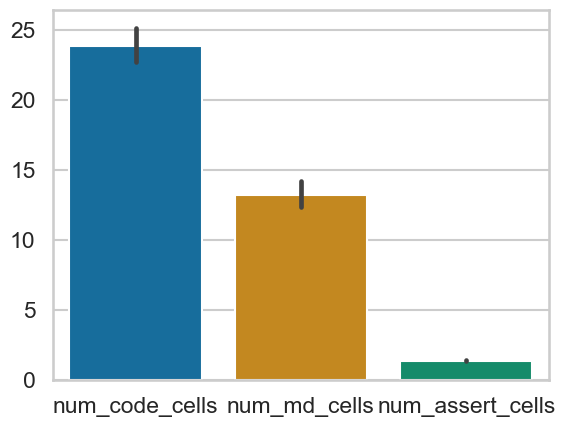

In [9]:
sns.barplot(data=stats.loc[:, ["num_code_cells", "num_md_cells", "num_assert_cells"]])

<Axes: >

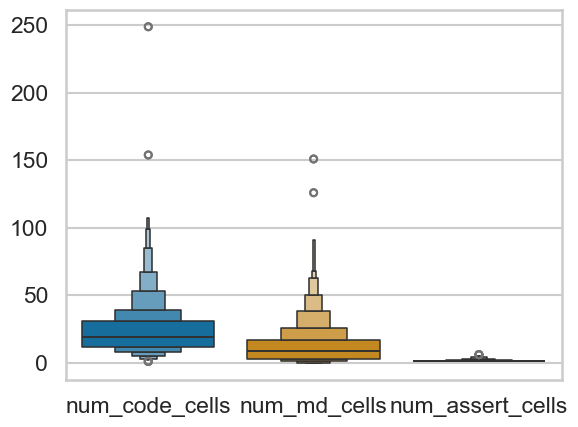

In [10]:
# TODO: stretch the boxplots more
sns.boxenplot(data=stats.loc[:, ["num_code_cells", "num_md_cells", "num_assert_cells"]])

We observe that in our population of notebooks, the number of code cells is more than the number of markdown cells. This is (probably) in line with the observations from [@quaranta2021kgtorrent].

On average, a notebook contains ~21 code cells but only ~1 

<Axes: ylabel='ratio'>

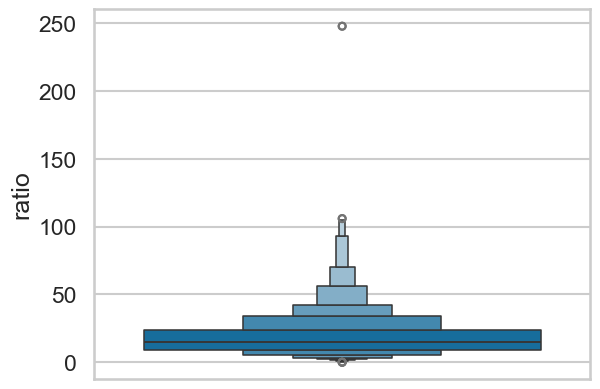

In [11]:
stats.loc[:, "ratio"] = (
    stats.loc[:, "code_cells_wo_assert"] / stats.loc[:, "num_assert_cells"]
)
sns.boxenplot(data=stats["ratio"])

The plot above depicts that the ratio of "code cells without an assert statement":"code cells with at least 1 assert statement" is on average approximately 20 indicating that the number of code cells without an assert statement is higher.

Lets investigate further.

In [12]:
stats["ratio"].describe()

count    1042.000000
mean       18.936724
std        18.283523
min         0.000000
25%         8.750000
50%        15.000000
75%        23.666667
max       248.000000
Name: ratio, dtype: float64

In [13]:
stats.loc[stats["ratio"] < 1]

,notebook,num_code_cells,num_md_cells,num_assert_cells,code_cells_wo_assert,ratio
136,data/mondal2023cell2doc/Cell2Doc-Artifacts/Rep...,1,1,1,0,0.0
332,data/mondal2023cell2doc/Cell2Doc-Artifacts/Rep...,1,2,1,0,0.0
463,data/mondal2023cell2doc/Cell2Doc-Artifacts/Rep...,3,1,2,1,0.5
657,data/mondal2023cell2doc/Cell2Doc-Artifacts/Rep...,1,1,1,0,0.0
853,data/mondal2023cell2doc/Cell2Doc-Artifacts/Rep...,1,2,1,0,0.0
984,data/mondal2023cell2doc/Cell2Doc-Artifacts/Rep...,3,1,2,1,0.5


## Anatomy of assert cells (content)

In this section we analyse the contents of assert cells.

In the data collection phase (see bin/data-collection.py script for more details) we flagged any code cells that contain the `assert` keyword. This may lead to false positive results (for instance, the keyword appears in a comment or in the name of a function call).

Thus the first order of business is to remove such false positive results from our analysis. We can do this by constructing an AST (Abstract Syntax Tree) for the code cells. Actual `assert` statements will then appear as an `ast.Assert` node in the tree.

We are interested in the following:
1. How many number of top-level nodes are present in assert cells?
1. How many assert statements are typically present in the code cells?
2. Are assert statements usually written as a standalone test? Or are they defined within function calls?
3. Are assert statements defined in dedicated "test" cells? Or are they mixed in with code performing other tasks?

Lets examine a single row in more detail.

In [14]:
example = assert_content.iloc[0]["source"]
print(example)

test_blocks = [
    list(range(0, 100000)) + list(range(300000, 400000)) + list(range(800000, 900000)) + list(range(1000000, 2000000)),
    list(range(400000, 500000)),
    list(range(100000, 200000)) + list(range(900000, 1000000)),
    list(range(200000, 300000)) + list(range(600000, 700000)),
    list(range(500000, 600000)) + list(range(700000, 800000))
]

# Sanity check
assert sum([len(x) for x in test_blocks]) == 2000000


In [15]:
tree = ast.parse(example)
print(ast.dump(tree, indent=True))

Module(
 body=[
  Assign(
   targets=[
    Name(id='test_blocks', ctx=Store())],
   value=List(
    elts=[
     BinOp(
      left=BinOp(
       left=BinOp(
        left=Call(
         func=Name(id='list', ctx=Load()),
         args=[
          Call(
           func=Name(id='range', ctx=Load()),
           args=[
            Constant(value=0),
            Constant(value=100000)],
           keywords=[])],
         keywords=[]),
        op=Add(),
        right=Call(
         func=Name(id='list', ctx=Load()),
         args=[
          Call(
           func=Name(id='range', ctx=Load()),
           args=[
            Constant(value=300000),
            Constant(value=400000)],
           keywords=[])],
         keywords=[])),
       op=Add(),
       right=Call(
        func=Name(id='list', ctx=Load()),
        args=[
         Call(
          func=Name(id='range', ctx=Load()),
          args=[
           Constant(value=800000),
           Constant(value=900000)],
          keywords=[])],
   

In [16]:
def get_top_level_nodes(source: str):
    nodes = [tree.__str__() for tree in ast.parse(source).body]
    nodes = list(map(lambda x: x.split("object")[0], nodes))
    nodes = list(map(lambda x: x.replace("<ast.", "").strip(), nodes))
    return nodes


assert_content.loc[:, "top_level_nodes"] = assert_content["source"].apply(
    get_top_level_nodes
)
assert_content.loc[:, "num_top_level_nodes"] = assert_content["top_level_nodes"].apply(
    lambda x: len(x)
)
assert_content["num_top_level_nodes"].describe()

<unknown>:13: SyntaxWarning: invalid escape sequence '\s'
<unknown>:415: SyntaxWarning: invalid escape sequence '\['
<unknown>:64: SyntaxWarning: invalid escape sequence '\w'
<unknown>:92: SyntaxWarning: invalid escape sequence '\w'
<unknown>:105: SyntaxWarning: invalid escape sequence '\s'
<unknown>:60: SyntaxWarning: invalid escape sequence '\w'
<unknown>:13: SyntaxWarning: invalid escape sequence '\s'
<unknown>:415: SyntaxWarning: invalid escape sequence '\['
<unknown>:64: SyntaxWarning: invalid escape sequence '\w'
<unknown>:92: SyntaxWarning: invalid escape sequence '\w'


count    1388.000000
mean        3.690922
std         6.107686
min         0.000000
25%         1.000000
50%         1.000000
75%         4.000000
max        91.000000
Name: num_top_level_nodes, dtype: float64

In [17]:
# investigate cells with no top level nodes
print(assert_content.loc[assert_content["num_top_level_nodes"] < 1].iloc[0].source)
# NOTE: this cell contains valid code but its all commented out. Another thing to look out for during data-preprocessing step!

# def compare_dataframes(df1, df1_description, df2, df2_description):
#     """
#     Analyze each feature and compare the difference between fraud and not fraud table
    
#     Args:
#         train_fraud (pd.DataFrame): contains the fraudulent transactions
#         train_not_fraud (pd.DataFrame): contains the non-fraud transactions
        
#     Returns:
        
#     """
    
#     # features that look interesting from visual inspection
#     features = ['TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card4', 'card6', 
#                 'P_emaildomain', 'R_emaildomain', 'id_29', 'id_30', 'id_31', 'DeviceType', 'DeviceInfo']
    
#     # Use this if analyzing ALL features of dataframes
#     # make sure have same features in both dataframes
#     #assert(sorted(train_not_fraud.columns) == sorted(train_fraud.columns))
#     #features = train_fraud.columns 
    
#     for feature in features:
#         # numerical feature
#         if df1[feature].dtype == 'int64' or df1[

In [18]:
assert_content = assert_content.loc[~assert_content["num_top_level_nodes"] < 1]
assert_content.shape

(1388, 5)

<Axes: ylabel='num_top_level_nodes'>

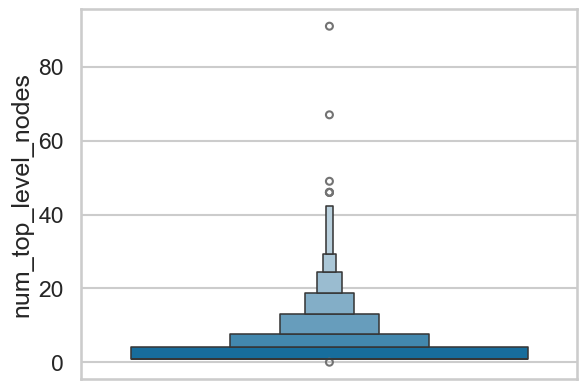

In [19]:
sns.boxenplot(data=assert_content["num_top_level_nodes"])

We observe that typically assert cells contain 1-2 top level nodes.

Next, lets check which top level nodes are most common.

In [20]:
assert_content["top_level_nodes"].head()

10                                     [Assign, Assert]
45       [ClassDef, Assign, Assign, Assert, Expr, Expr]
6     [Expr, Import, Import, Import, Import, Import,...
7     [Expr, Import, Import, Import, ClassDef, Class...
8            [Import, Import, FunctionDef, FunctionDef]
Name: top_level_nodes, dtype: object

In [21]:
top_nodes = assert_content["top_level_nodes"].explode()

In [22]:
top_nodes.value_counts().sort_values(ascending=False)

top_level_nodes
Assign         1235
FunctionDef    1216
Expr            938
ClassDef        484
ImportFrom      447
Import          413
Assert          273
For              60
If               30
Delete           11
With              6
Try               5
AnnAssign         4
While             1
Name: count, dtype: int64

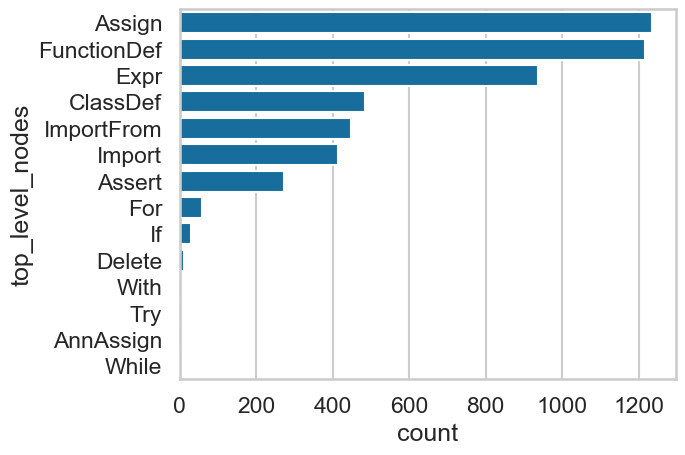

In [23]:
ax = sns.barplot(data=top_nodes.value_counts().sort_values(ascending=False), errorbar=None, orient="h")

Some reasoning:
Our data consists only of code cells where the keyword `assert` appeared somewhere. There are several possibilities here:
1. we have a assertion defined as a top level node (standalone assert statement)
2. the assertion is defined inside a function definition (not top level)
3. the keyword `assert` appears in the name of a function/variable definition
4. the keyword `assert` appears in a comment

We can dig deeper into the location of the assertions next. Lets separate our asserts into two buckets: top-level and not top-level.

The `ast` module ignores comments so if we have cells with no `Assert` nodes (top-level or otherwise), we then know that these cells contained a comment with the `assert` keyword.


In [24]:
has_top_level_assert = assert_content.loc[assert_content["top_level_nodes"].apply(lambda x: "Assert" in x)]
has_top_level_assert.shape

(168, 5)

Lets investigate the proportion of `Assert` vs non-`Assert` nodes in cells where a top level `Assert` not was present. I want to see if developers tend to group such assertions together in a single cell.

In [25]:
def count_assert_nodes(nodes: list) -> int:
    assert_nodes = list(filter(lambda x: x == "Assert", nodes))
    return len(assert_nodes)


has_top_level_assert.loc[:, "num_top_level_assert_nodes"] = has_top_level_assert["top_level_nodes"].apply(count_assert_nodes)
has_top_level_assert.loc[:, "num_top_level_other_nodes"] = has_top_level_assert["num_top_level_nodes"] - has_top_level_assert["num_top_level_assert_nodes"]
has_top_level_assert.head()

/var/folders/3_/dh2k952n2rld3_w3r369mln80000gn/T/ipykernel_64762/914937091.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  has_top_level_assert.loc[:, "num_top_level_assert_nodes"] = has_top_level_assert["top_level_nodes"].apply(count_assert_nodes)
/var/folders/3_/dh2k952n2rld3_w3r369mln80000gn/T/ipykernel_64762/914937091.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  has_top_level_assert.loc[:, "num_top_level_other_nodes"] = has_top_level_assert["num_top_level_nodes"] - has_top_level_assert["num_t

,cell_type,source,notebook,top_level_nodes,num_top_level_nodes,num_top_level_assert_nodes,num_top_level_other_nodes
10,code,"test_blocks = [\n list(range(0, 100000)) + ...",data/mondal2023cell2doc/Cell2Doc-Artifacts/Rep...,"[Assign, Assert]",2,1,1
45,code,class InferenceConfig(FashionConfig):\n GPU...,data/mondal2023cell2doc/Cell2Doc-Artifacts/Rep...,"[ClassDef, Assign, Assign, Assert, Expr, Expr]",6,1,5
54,code,y_train = (\n meta_train_df.groupby('id_mea...,data/mondal2023cell2doc/Cell2Doc-Artifacts/Rep...,"[Assign, Assert]",2,1,1
105,code,assert np.all(submission['signal_id'].values =...,data/mondal2023cell2doc/Cell2Doc-Artifacts/Rep...,"[Assert, Assign]",2,1,1
18,code,"valid_preds = np.random.randint(4, size=valid_...",data/mondal2023cell2doc/Cell2Doc-Artifacts/Rep...,"[Assign, Assign, Assign, Expr, Assert]",5,1,4


<Axes: >

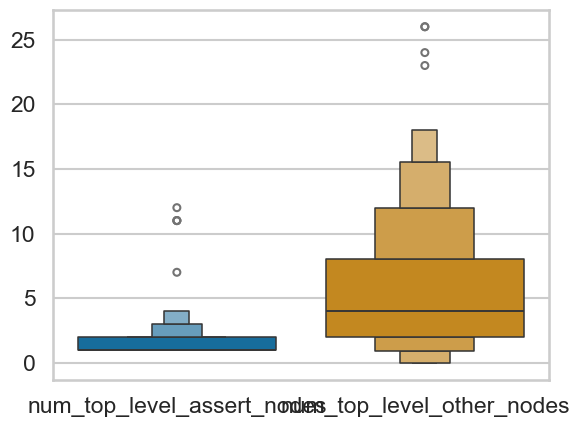

In [26]:
sns.boxenplot(data=has_top_level_assert.loc[:, ["num_top_level_assert_nodes", "num_top_level_other_nodes"]])


For the current sample of notebooks, it does not appear that `assert` statements are written together in a dedicated cell. This however may change when we analyse the full dataset.

Lets investigate the composition of top-level assert nodes next. Here we are interested in the following:
+ What are the most commonly used operator in ML asserts?
+ What are the most commonly occuring RHS in assertions
    + if they are a constant, what is the most commonly used value used?
+ Do the asserts contain a failure message?

In [27]:
def get_assert_nodes(nodes: list):
    return [n for n in nodes if isinstance(n, ast.Assert)]


def get_compare_nodes(nodes: list[ast.Assert]):
    return [n for node in nodes for n in ast.walk(node) if isinstance(n, ast.Compare)]


def get_compare_ops_nodes(nodes: list[ast.Compare]):
    return [node.ops for node in nodes]

In [28]:
def get_assert_nodes(source: str):
    return [node for node in ast.walk(ast.parse(source)) if isinstance(node, ast.Assert)]

def get_node_name(node):
    return node.__str__().split("object")[0].replace("<ast.", "").strip()


top_assert_nodes = has_top_level_assert.loc[:, "source"].apply(get_assert_nodes)
top_assert_nodes = top_assert_nodes.explode()
top_tests = top_assert_nodes.apply(lambda x: x.test).apply(get_node_name)
top_messages = top_assert_nodes.apply(lambda x: x.msg)

In [29]:
top_tests.value_counts().sort_values(ascending=False)

source
Compare    216
Call        43
BoolOp      10
UnaryOp      8
Name: count, dtype: int64

<Axes: xlabel='source', ylabel='count'>

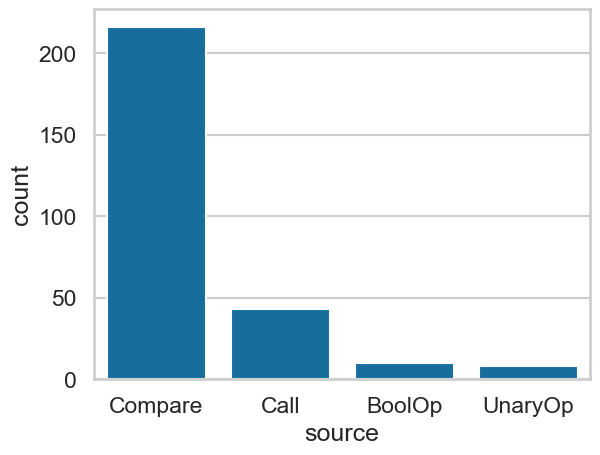

In [30]:
sns.barplot(data=top_tests.value_counts().sort_values(ascending=False))

Majority of the assertions contain a comparison operator. This aligns with our prior observations from the ICST paper. Lets dig deeper into the `Compare` operator next.

In [31]:
# NOTE: construct series of Compare nodes which were in the `test` attribute of top level `Assert` statements
top_compare_nodes = pd.Series(
    data=[
        node.test
        for _, node in top_assert_nodes.items()
        if isinstance(node.test, ast.Compare)
    ]
)
top_compare_content = pd.DataFrame(data={
    "left": top_compare_nodes.apply(lambda x: x.left),
    "ops": top_compare_nodes.apply(lambda x: x.ops),
    "comparators": top_compare_nodes.apply(lambda x: x.comparators),
})
top_compare_content.head()

,left,ops,comparators
0,<ast.Call object at 0x12dcc8790>,[<ast.Eq object at 0x10fd4c850>],[<ast.Constant object at 0x12dcc8e50>]
1,<ast.Name object at 0x12dcbdc90>,[<ast.NotEq object at 0x10fd4c8d0>],[<ast.Constant object at 0x12dcbdd90>]
2,<ast.Subscript object at 0x12dcbc2d0>,"[<ast.Eq object at 0x10fd4c850>, <ast.Eq objec...","[<ast.Subscript object at 0x12dcbd510>, <ast.S..."
3,<ast.Attribute object at 0x12dcf13d0>,[<ast.Eq object at 0x10fd4c850>],[<ast.Constant object at 0x12dcf1210>]
4,<ast.Subscript object at 0x12dcf10d0>,[<ast.Eq object at 0x10fd4c850>],[<ast.Constant object at 0x12dcf0e10>]


Some things to look into:
+ Do we have assertions where multiple ops are used? (eg. `assert a < 1 >= b`)
+ What is the most common ops used?
+ What is the most common comparator used?
    + if its a `Constant`, what is the most common value?
+ What is the most common left?

In [32]:
top_compare_content.loc[top_compare_content["ops"].apply(lambda x: len(x) >1)].shape

(7, 3)

We have 7 examples where more than 1 ops was used.

In [47]:
top_compare_content["ops"].explode().apply(get_node_name).value_counts().sort_values(ascending=False)

ops
Eq       201
NotEq     14
Lt         4
Gt         2
IsNot      1
LtE        1
In         1
Name: count, dtype: int64

<Axes: xlabel='ops', ylabel='count'>

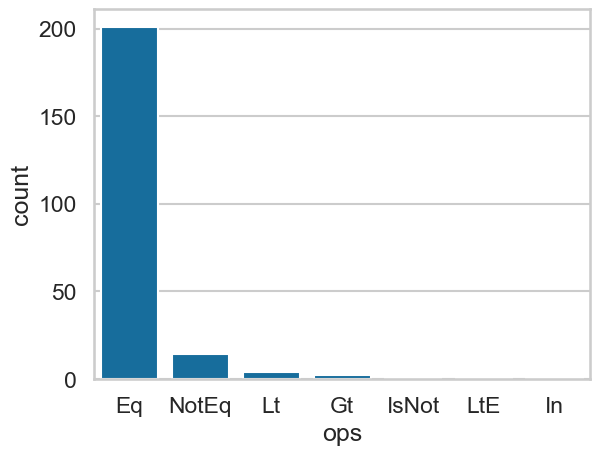

In [35]:
sns.barplot(data=top_compare_content["ops"].explode().apply(get_node_name).value_counts().sort_values(ascending=False))

For the given sample, the assertions mostly use the `==` operator. Lets analyse the comparators next.

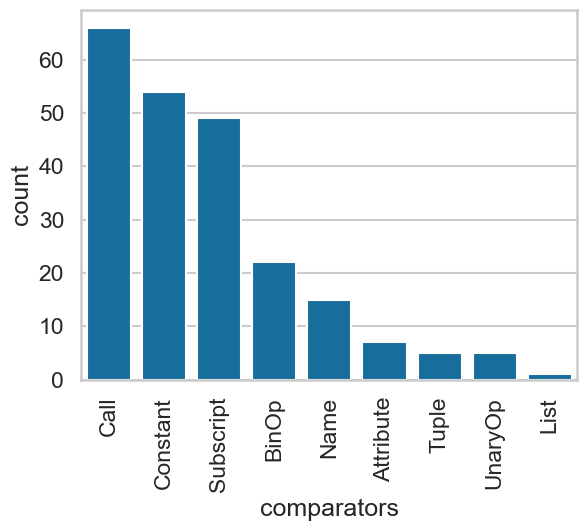

In [49]:
ax = sns.barplot(data=top_compare_content["comparators"].explode().apply(get_node_name).value_counts().sort_values(ascending=False))
ax.tick_params(axis="x", rotation=90)

The RHS usually calls a function or contains a constant. Lets see the most frequently occuring constants and try to map them back to the assertions.

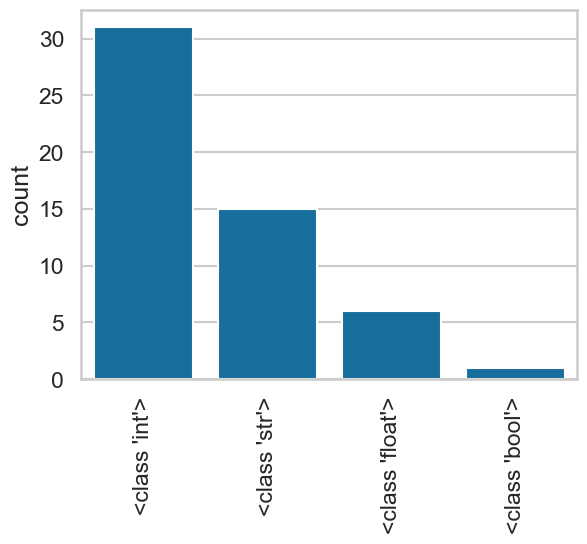

In [64]:
constants  = pd.Series(
    data=[
        node.value
        for _, node in top_compare_content["comparators"].explode().items()
        if isinstance(node, ast.Constant)
    ]
)
constants = constants.dropna()
ax = sns.barplot(data=constants.apply(lambda x: type(x)).value_counts().sort_values(ascending=False))
ax.tick_params(axis="x", rotation=90)

In [70]:
example = top_compare_nodes.iloc[0]
example

fields = [field for field in ast.iter_fields(example)]
name, tree = fields[0]
[field for field in ast.iter_fields(tree)]


[('func', <ast.Name at 0x12dcc87d0>),
 ('args', [<ast.ListComp at 0x12dcc88d0>]),
 ('keywords', [])]

## Context of assert cells

In this section we focus 